**<h3> 사전 준비 </h3>**
필요한 Module들을 준비합니다.

In [1]:
!pip install kaggle torch torchvision matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import os
import shutil
import zipfile
from tqdm import tqdm
from google.colab import files

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


**<h3> 데이터 </h3>**
10개의 Dataset 중 4번째, Vegetable Image Dataset을 사용했습니다. <br>
Training 데이터에만 15도 회전, 좌우반전의 Data Augmentation을 하였습니다.

In [5]:
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/")
os.chmod("/root/.kaggle/kaggle.json", 600)

In [6]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Download the Kaggle dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0


In [8]:
# Define dataset paths
dataset_path = "./Vegetable Images"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

In [9]:
# Image Transformations for ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Data Augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG16 expected input size
    transforms.RandomRotation(15),  # Random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% flip horizontally
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Load Dataset
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

In [12]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Get number of classes
num_classes = len(train_dataset.classes)

**<h3> 모델 </h3>**
VGG16을 가져와 Transfer learning을 하였습니다. <br>

In [14]:
# Load Pretrained VGG16 Model
model = models.vgg16(pretrained=True)

# Freeze all layers except the final classifier
for param in model.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 116MB/s]


In [15]:
# Modify the classifier for our dataset
model.classifier[6] = nn.Linear(4096, num_classes)

# Move model to device
model = model.to(device)

In [16]:
# Loss, Optim, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
# Early Stopping
early_stopping_patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

**<h3> 데이터베이스 </h3>**
학습 로그를 저장하기 위한 데이터베이스를 구성합니다.

In [18]:
import sqlite3

In [19]:
# Create/connect to a database file
conn = sqlite3.connect("training_logs.db")
cursor = conn.cursor()

In [20]:
# Create table for logs
cursor.execute('''
CREATE TABLE IF NOT EXISTS logs (
    model TEXT,
    epoch INTEGER,
    train_loss REAL,
    val_loss REAL,
    val_accuracy REAL
)
''')
conn.commit()

In [21]:
def insert_log(model_name, epoch, train_loss, val_loss, val_acc):
    cursor.execute('''
        INSERT INTO logs (model, epoch, train_loss, val_loss, val_accuracy)
        VALUES (?, ?, ?, ?, ?)
    ''', (model_name, epoch, train_loss, val_loss, val_acc))
    conn.commit()

**<h3> 학습 </h3>**
실제로 학습을 진행합니다.

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    global best_val_loss, early_stop_counter
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        running_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = correct / total
        val_accs.append(val_acc)

        insert_log("VGG16", epoch+1, avg_train_loss, avg_val_loss, val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Learning Rate Scheduler Step
        scheduler.step(avg_val_loss)

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0  # Reset counter
            print("Model improved!")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

        if early_stop_counter >= early_stopping_patience:
            print("Early stopping triggered! Training halted.")
            break

    return train_losses, val_losses, val_accs

In [23]:
# Train Model
epochs = 50
train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

Epoch 1/50 - Train Loss: 0.1731, Val Loss: 0.0294, Val Acc: 0.9897
Model improved!


Epoch 2/50 - Train Loss: 0.0576, Val Loss: 0.0510, Val Acc: 0.9923
No improvement. Early stopping counter: 1/5


Epoch 3/50 - Train Loss: 0.0511, Val Loss: 0.0187, Val Acc: 0.9960
Model improved!


Epoch 4/50 - Train Loss: 0.0343, Val Loss: 0.0200, Val Acc: 0.9947
No improvement. Early stopping counter: 1/5


Epoch 5/50 - Train Loss: 0.0497, Val Loss: 0.0126, Val Acc: 0.9977
Model improved!


Epoch 6/50 - Train Loss: 0.0443, Val Loss: 0.0822, Val Acc: 0.9887
No improvement. Early stopping counter: 1/5


Epoch 7/50 - Train Loss: 0.0311, Val Loss: 0.0425, Val Acc: 0.9943
No improvement. Early stopping counter: 2/5


Epoch 8/50 - Train Loss: 0.0394, Val Loss: 0.0484, Val Acc: 0.9937
No improvement. Early stopping counter: 3/5


Epoch 9/50 - Train Loss: 0.0662, Val Loss: 0.0934, Val Acc: 0.9890
No improvement. Early stopping counter: 4/5


Epoch 10/50 - Train Loss: 0.0113, Val Loss: 0.0367, Val Acc: 0.9967
No improvement. Early stopping counter: 5/5
Early stopping triggered! Training halted.


**<h3> 결과 </h3>**
Loss 및 Accuracy를 그래프로 나타냅니다.

Text(0.5, 1.0, 'Loss Over Epochs')

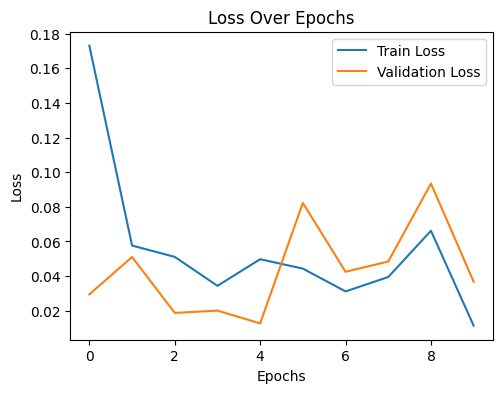

In [24]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")

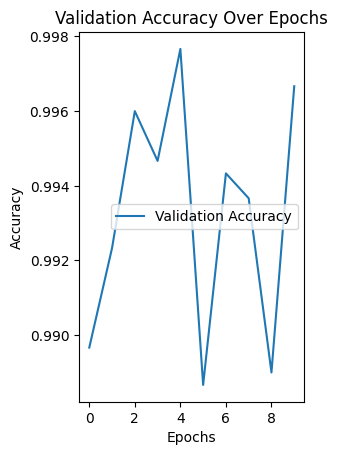

In [25]:
# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")

plt.show()

**<h3> 테스트 </h3>**
실제 Test set에서 Task를 수행합니다.

In [26]:
# Model Evaluation on Test Set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

In [27]:
# Evaluate the model
evaluate_model(model, test_loader)

Test Accuracy: 0.9970


**<h3> 쿼리 </h3>**
데이터베이스에 저장된 로그를 확인해봅니다.

In [30]:
for row in cursor.execute("SELECT * FROM logs WHERE val_loss<0.05"):
    print(row)

('VGG16', 1, 0.17308672888036347, 0.02941655340224247, 0.9896666666666667)
('VGG16', 3, 0.05105294240367168, 0.01869500077773574, 0.996)
('VGG16', 4, 0.03434515938903888, 0.020018267420811805, 0.9946666666666667)
('VGG16', 5, 0.04972107921152489, 0.012612428294577415, 0.9976666666666667)
('VGG16', 7, 0.031110558099421294, 0.04246848735219442, 0.9943333333333333)
('VGG16', 8, 0.03942679291424414, 0.04837508146343465, 0.9936666666666667)
('VGG16', 10, 0.011285620321358394, 0.03673942656733058, 0.9966666666666667)
